In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import albumentations as A
DATA_DIR = "/home/ljj0512/shared/data"

In [6]:
print(1e-4)

0.0001


In [19]:
# print(os.listdir(DATA_DIR))
train_dir = os.path.join(DATA_DIR, "Train")
# print(train_dir)
# print(glob.glob(os.path.join(train_dir, "*")))

for path in glob.glob(os.path.join(train_dir, "*")):
    print(f"path {path}:",len(os.listdir(path)))

path /home/ljj0512/shared/data/Train/Normal: 4002
path /home/ljj0512/shared/data/Train/Lung_Cancer: 1001
path /home/ljj0512/shared/data/Train/pneumonia: 1001
path /home/ljj0512/shared/data/Train/pneumothorax: 1001
path /home/ljj0512/shared/data/Train/ILD: 1001


In [83]:
classes = {
    "Normal":0,
    "Lung_Cancer":1,
    "ILD":2,
    "pneumonia":3,
    "pneumothorax":4
}
train_dir = os.path.join(DATA_DIR, "Train")
img_path_list = []
label_list = []
for i, path in enumerate(glob.glob(os.path.join(train_dir, "*"))):
    print(path)
    for img_name in os.listdir(path):
        if img_name == ".DS_Store":
            print("pass")
        else:
            img_path_list.append(os.path.join(path, img_name))
            label_list.append(classes[path.split("/")[-1]])

train_df = pd.DataFrame({ "image_path":img_path_list,
                          "label":label_list    })

/home/ljj0512/shared/data/Train/Normal
pass
/home/ljj0512/shared/data/Train/Lung_Cancer
pass
/home/ljj0512/shared/data/Train/pneumonia
pass
/home/ljj0512/shared/data/Train/pneumothorax
pass
/home/ljj0512/shared/data/Train/ILD


In [84]:
train_df

,image_path,label
0,/home/ljj0512/shared/data/Train/Normal/ChestCT...,0
1,/home/ljj0512/shared/data/Train/Normal/ChestCT...,0
2,/home/ljj0512/shared/data/Train/Normal/ChestCT...,0
3,/home/ljj0512/shared/data/Train/Normal/ChestCT...,0
4,/home/ljj0512/shared/data/Train/Normal/ChestCT...,0
...,...,...
7996,/home/ljj0512/shared/data/Train/ILD/ChestCT_IL...,2
7997,/home/ljj0512/shared/data/Train/ILD/ChestCT_IL...,2
7998,/home/ljj0512/shared/data/Train/ILD/ChestCT_IL...,2
7999,/home/ljj0512/shared/data/Train/ILD/ChestCT_IL...,2


In [87]:
train_df.to_csv("train_df.csv")

In [85]:
classes = {
    "Normal":0,
    "Lung_Cancer":1,
    "ILD":2,
    "pneumonia":3,
    "pneumothorax":4
}
val_dir = os.path.join(DATA_DIR, "Validation")
img_path_list = []
label_list = []
for i, path in enumerate(glob.glob(os.path.join(val_dir, "*"))):
    print(path)
    for img_name in os.listdir(path):
        if img_name == ".DS_Store":
            print("pass")
        img_path_list.append(os.path.join(path, img_name))
        label_list.append(classes[path.split("/")[-1]])

val_df = pd.DataFrame({ "image_path":img_path_list,
                          "label":label_list    })

/home/ljj0512/shared/data/Validation/Normal
/home/ljj0512/shared/data/Validation/Lung_Cancer
/home/ljj0512/shared/data/Validation/pneumonia
/home/ljj0512/shared/data/Validation/pneumothorax
/home/ljj0512/shared/data/Validation/ILD


In [86]:
val_df


,image_path,label
0,/home/ljj0512/shared/data/Validation/Normal/Ch...,0
1,/home/ljj0512/shared/data/Validation/Normal/Ch...,0
2,/home/ljj0512/shared/data/Validation/Normal/Ch...,0
3,/home/ljj0512/shared/data/Validation/Normal/Ch...,0
4,/home/ljj0512/shared/data/Validation/Normal/Ch...,0
...,...,...
995,/home/ljj0512/shared/data/Validation/ILD/Chest...,2
996,/home/ljj0512/shared/data/Validation/ILD/Chest...,2
997,/home/ljj0512/shared/data/Validation/ILD/Chest...,2
998,/home/ljj0512/shared/data/Validation/ILD/Chest...,2


In [88]:
val_df.to_csv("val_df.csv")

In [79]:
i = 900
print(val_df["image_path"][i])
print(val_df["label"][i])
print(val_df.shape[0])

/home/ljj0512/shared/data/Validation/ILD/ChestCT_ILD_00001267.png
2
1000


In [80]:
print(train_df["image_path"][8000])
print(train_df["label"][8000])
print(train_df.shape[0])

/home/ljj0512/shared/data/Train/ILD/ChestCT_ILD_00000155.png
2
8006


================================================

In [5]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
import albumentations as A
DATA_DIR = "/home/ljj0512/shared/data"

In [6]:
from PIL import Image
from skimage import io
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        img_path = self.df["image_path"].iloc[index]
        if self.transform:
            image = self.transform(Image.open(img_path))
        else:
            image = io.imread(img_path) # numpy array로 읽어옴
        label = self.df["label"].iloc[index]
        return [image, label]

In [7]:
def get_transform(param):
    if param == "train":
        transform = transforms.Compose([
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                    ])
    elif param == "valid":
        transform = transforms.Compose([
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                    ])
    return transform
    


In [8]:
import pandas as pd
train_df = pd.read_csv("train_df.csv")
train_set = CustomDataset(train_df, transform=get_transform("train"))
train_loader = DataLoader(dataset=train_set,
                                batch_size=16,
                                shuffle=True,
                                num_workers=4)

In [99]:
import time
import torch.nn as nn
import numpy as np
from sklearn import metrics
from torchvision.models import EfficientNet_B6_Weights, efficientnet_b6
import torchvision.models as models

model = models.efficientnet_b6(weights=EfficientNet_B6_Weights.DEFAULT)
model.classifier[1] = nn.Linear(in_features=2304, out_features=5, bias=True)
model.cuda()
model.eval()
pred_labels = []
true_labels = []
total = 0
correct = 0
threshold = 0.5
criterion = nn.CrossEntropyLoss()

for i, (input, target) in enumerate(train_loader):
    target = target.cuda()
    input = input.cuda()
    true_labels += target.tolist()

    output = model(input)
    loss = criterion(output, target)

    # measure accuracy and record loss
    _, predicted = torch.max(output.data, dim=1)
    total += target.size(0)
    correct += predicted.eq(target.data).cpu().sum()
    output = output.squeeze(1).to('cpu')
    print(output.shape)
    pred_labels += output.tolist()


pred_labels = np.where(np.array(pred_labels) > threshold, 1, 0)
f1_score = metrics.f1_score(y_true=true_labels, y_pred=pred_labels, average='macro')
print(f1_score)

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.70 GiB total capacity; 7.40 GiB already allocated; 10.69 MiB free; 7.42 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

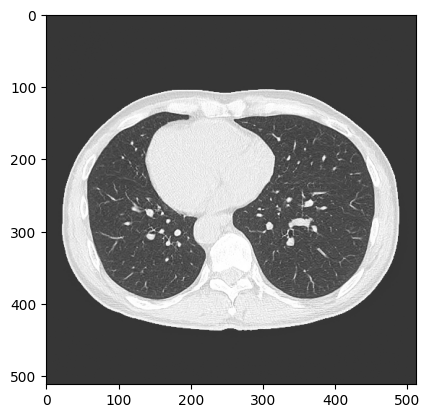

torch.Size([3, 512, 512])
0


In [82]:
i = 999
plt.imshow(train_set[i][0].permute(1,2,0))
plt.show()
print(train_set[i][0].shape)
print(train_set[i][1])

In [8]:
trainset = ImageFolder(root = DATA_DIR+"/Train",
                        transform = get_transform("train"))

validationset = ImageFolder(root = DATA_DIR+"/Validation",
                            transform = get_transform("valid"))

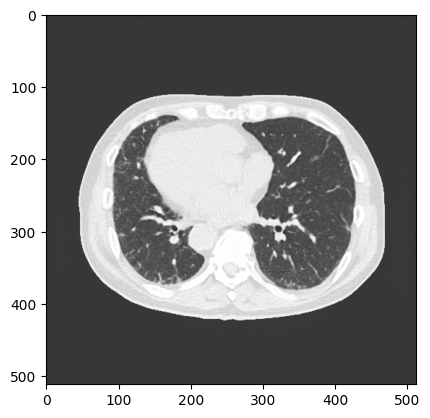

torch.Size([3, 512, 512])
0
8001
1000


In [30]:
import matplotlib.pyplot as plt

i = 999
plt.imshow(trainset[i][0].permute(1,2,0))
plt.show()
print(trainset[i][0].shape)
print(trainset[i][1])
print(len(trainset))
print(len(validationset))

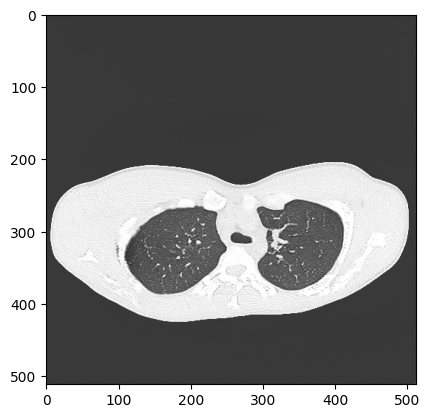

In [16]:
from skimage import io
x = io.imread("/home/ljj0512/shared/data/Train/pneumothorax/ChestCT_Pneumothorax_00001569.png")
plt.imshow(x)

In [90]:
class TestDataset(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        self.dir = "/home/ljj0512/shared/data/test"
    
    def __len__(self):
        return len(os.listdir(self.dir))

    def __getitem__(self, index):
        img_path = os.listdir(self.dir)[index]
        image = self.transform(Image.open(img_path))
        return image
transform = transforms.Compose([
                        transforms.ToTensor(),
                    ])
test_set = TestDataset(transform=transform)
print(len(test_set))


999


In [21]:
import torch
x = torch.randn((16,5))
output = torch.randn((16,5))
_, predicted = torch.max(output.data, dim=1)
print(predicted.shape)
print(predicted)
print(predicted.cpu().tolist())
predicted = predicted.cpu().tolist()
L = []
L += predicted
print(L)

torch.Size([16])
[4, 1, 3, 0, 1, 3, 1, 1, 2, 0, 0, 3, 4, 0, 3, 4]
[4, 1, 3, 0, 1, 3, 1, 1, 2, 0, 0, 3, 4, 0, 3, 4]
[4, 1, 3, 0, 1, 3, 1, 1, 2, 0, 0, 3, 4, 0, 3, 4]


In [29]:
print('Epoch: [{0}/{1}][{2}/{3}]\t''LR: {4}\t'
            # 'LR: {LR:.6f}\t'
            # 'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            # 'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            # 'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
            # 'Accuracy {acc:.4f}({cor}/{total})\t'
            # 'Top 1-err {top1.val:.4f} ({top1.avg:.4f})\t'
            # 'Top 5-err {top5.val:.4f} ({top5.avg:.4f})'
        .format([1,2], 100, 2, 50,312))

Epoch: [[1, 2]/100][2/50]	LR: 312	
